In [2]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py as h5
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import KDTree
from numpy import inf


In [3]:
def WGS84toEASE2N(lon, lat):
    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)

    return x, y


def LOAD_MISR_H5(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    roughness = file['Roughness']['Roughness_2D_svm']
    data = np.array(roughness)
    file.close()
    
    return data


def MISR_COORDS(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    lon_MISR = np.array(file['GeoLocation']['Longitude'])
    lat_MISR = np.array(file['GeoLocation']['Latitude'])
    x_MISR = np.array(file['GeoLocation']['x'])
    y_MISR = np.array(file['GeoLocation']['y'])
    file.close()
    
    return lon_MISR, lat_MISR, x_MISR, y_MISR



def LOAD_MPF(MPF_path): 
    # Loads data from Sangyun Lee dataset on CPOM servers, just for month of JULY
    file_path = MPF_path
    ds = xr.open_dataset(file_path)
    data = np.array(ds['july_monthly'])
    
    return data

    

def MPF_UCL_COORDS(MPF_UCL_cords_path): 
    # reads coordinate data from sangyun lee mpf data set
    file_path = MPF_UCL_cords_path
    ds = xr.open_dataset(file_path)
    lon_MPF = ds['mp_lon']
    lat_MPF = ds['mp_lat']
        
    return np.asarray(lon_MPF), np.asarray(lat_MPF)


def interpolate_to_MISR(X_grid_in,Y_grid_in,Z_in,X_grid_out,Y_grid_out): 
    # function interpolates z data in which has shape X_in, Y_in to the same shape as X_out, Y_out
    z = griddata((X_grid_in.ravel(),Y_grid_in.ravel()),Z_in.ravel(),(X_grid_out.ravel(),Y_grid_out.ravel()),'nearest').reshape(1000,1000) 
    # to actually interpolate to MISR, need MISR x, y grid in and to reshape to 8000x8000 but can work with other shapes
    return z


# custom function to pass to statistic 
def nanmean(x):
    return np.nanmean(x)


def calculate_binned_averages(mpf, roughness, lat):

    mpf = mpf.ravel()
    roughness = roughness.ravel()
    lat = lat.ravel()

    # Define the number of bins for latitude and roughness
    num_lat_bins = 30
    num_rough_bins = 20

    # Calculate the 2D binning and get the average values of mpf in each bin
    averages, _, _, _ = binned_statistic_2d(
        lat,
        roughness,
        mpf,
        statistic = nanmean,
        bins=[num_lat_bins, num_rough_bins],
        range=[[60, 90], [0, 0.5]]
    )

    return averages


def plot_binned_stats(averages, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.set_cmap('cubehelix_r')
    plt.pcolor(averages)
    plt.title(title)
    plt.colorbar()

    # Show the plot
    plt.show()


def plot_binned_accuracy(accuracy, colour_map, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(accuracy, cmap = colour_map)
    plt.title(title)
    plt.colorbar()

    # Show the plot
    plt.show()


def MASK_MPF_MISR(mpf_MISRGRID, MISR):
    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf_MISRGRID)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_MPF_MISRGRID = np.ma.masked_array(mpf_MISRGRID, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    return masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"


def perc_diff(predicted, observed):
    return (predicted - observed) / ((predicted + observed) / 2) * 100


### Load roughness data and coords, and lat/lon paths

Load MISR

Number of points: 1000000
MISR shape: (1000, 1000)


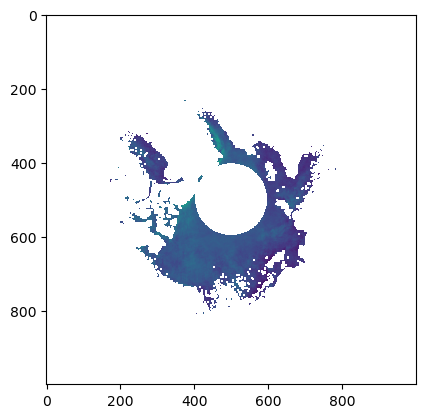

In [21]:
YEAR = 2017

# Retrieving coordinate data for MISR, using 2020 but all lat lon data identical. Ready transformed x and y
misr_path = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(misr_path)

MISR = LOAD_MISR_H5(misr_path)[::8,::8]
lon_MISR = lon_MISR[::8,::8]
lat_MISR = lat_MISR[::8,::8]
x_MISR = x_MISR[::8,::8]
y_MISR = y_MISR[::8,::8]
num_points = len(MISR.ravel())
print(f'Number of points: {num_points}')
print(f'MISR shape: {np.shape(MISR)}')

plt.imshow(MISR)

Load MPF and trajectories

MPF shape: (184, 1000000)
Lat shape: (184, 1000000)
Lon shape: (184, 1000000)


/tmp/ipykernel_282564/538834374.py:16: RuntimeWarning: Mean of empty slice
  mpf = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


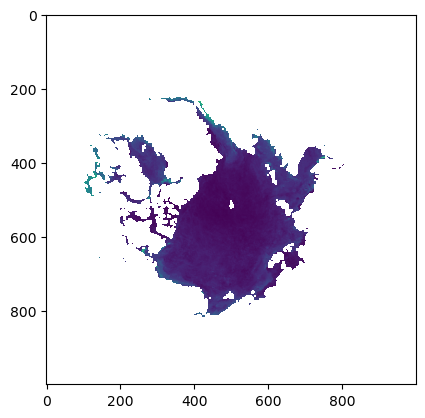

In [31]:
mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{YEAR}0401_183_days_spacing_8.pkl')
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183_days_spacing_8.pkl')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183_days_spacing_8.pkl')

print(f'MPF shape: {mpf_advected.shape}')
print(f'Lat shape: {lat_advected.shape}')
print(f'Lon shape: {lon_advected.shape}')

date_from = format_date(YEAR, '05', '01')
date_to = format_date(YEAR, '05', '31')

subset_mpf = np.asarray(mpf_advected.loc[date_from:date_to])
subset_lat = np.asarray(lat_advected.loc[date_from:date_to])
subset_lon = np.asarray(lon_advected.loc[date_from:date_to])

mpf = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
np.shape(mpf)

plt.imshow(mpf)


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

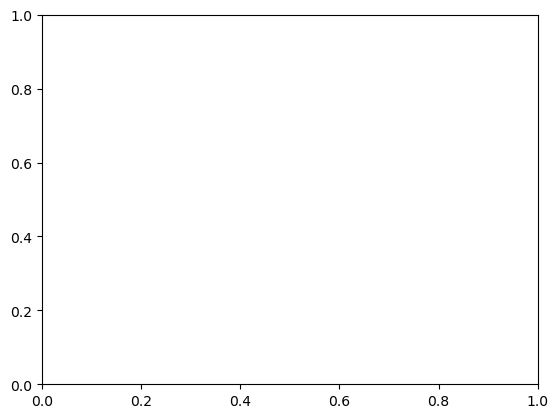

In [42]:
x = np.load(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/x_{YEAR}.npy')
y = np.load(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/y_{YEAR}.npy')

subset_x = np.asarray(x[31:62])
subset_y = np.asarray(y[31:62])

plt.pcolormesh(subset_x[30].reshape(1000,1000), subset_y[30].reshape(1000,1000), subset_mpf[30].reshape(1000,1000))


/tmp/ipykernel_116838/1223713366.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(subset_lon[0,:].reshape(1000,1000), subset_lat[0,:].reshape(1000,1000), subset_mpf[0,:].reshape(1000,1000))


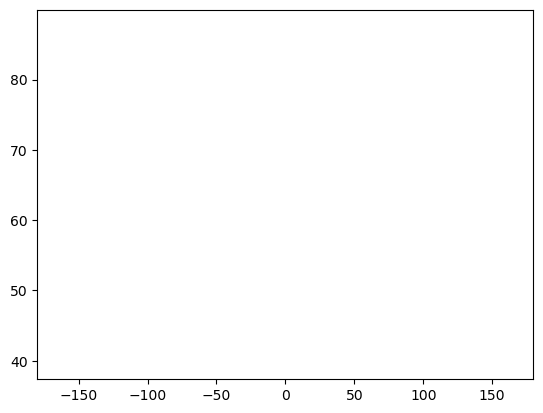

In [6]:
plt.pcolormesh(subset_lon[0,:].reshape(1000,1000), subset_lat[0,:].reshape(1000,1000), subset_mpf[0,:].reshape(1000,1000))

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

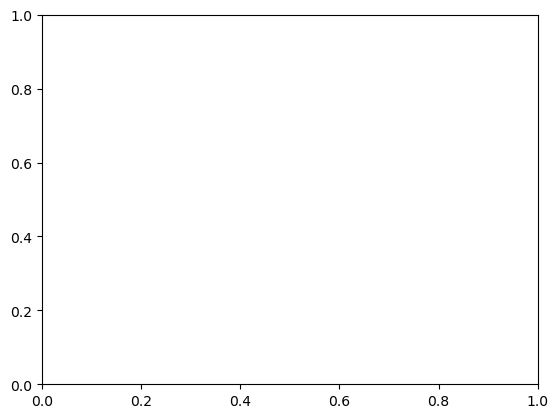

In [17]:
plt.pcolormesh(subset_x[0,:].reshape(1000,1000), subset_y[0,:].reshape(1000,1000), subset_mpf[0,:].reshape(1000,1000))

### Make new dataframes with x and y coords

In [30]:
days = len(lat_advected[:][0])
num_points = len(lat_advected.iloc[0])
x = np.zeros((days, num_points)) * np.nan
y = np.zeros((days, num_points)) * np.nan

for i in range(days):
    print(f'Processing day {i+1} of {days}')
    x[i,:], y[i,:] = WGS84toEASE2N(np.asarray(lat_advected.iloc[i]), np.asarray(lon_advected.iloc[i]))

x[x == inf] = np.nan
y[y == inf] = np.nan

# save new coords
np.save(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/x_{YEAR}.npy', x)
np.save(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/y_{YEAR}.npy', y)


Processing day 1 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 2 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 3 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 4 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 5 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 6 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 7 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 8 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 9 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 10 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 11 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 12 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 13 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 14 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 15 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 16 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 17 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 18 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 19 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 20 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 21 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 22 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 23 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 24 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 25 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 26 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 27 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 28 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 29 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 30 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 31 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 32 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 33 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 34 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 35 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 36 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 37 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 38 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 39 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 40 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 41 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 42 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 43 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 44 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 45 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 46 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 47 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 48 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 49 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 50 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 51 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 52 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 53 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 54 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 55 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 56 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 57 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 58 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 59 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 60 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 61 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 62 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 63 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 64 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 65 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 66 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 67 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 68 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 69 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 70 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 71 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 72 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 73 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 74 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 75 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 76 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 77 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 78 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 79 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 80 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 81 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 82 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 83 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 84 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 85 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 86 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 87 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 88 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 89 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 90 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 91 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 92 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 93 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 94 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 95 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 96 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 97 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 98 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 99 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 100 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 101 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 102 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 103 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 104 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 105 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 106 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 107 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 108 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 109 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 110 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 111 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 112 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 113 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 114 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 115 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 116 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 117 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 118 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 119 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 120 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 121 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 122 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 123 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 124 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 125 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 126 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 127 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 128 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 129 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 130 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 131 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 132 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 133 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 134 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 135 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 136 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 137 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 138 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 139 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 140 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 141 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 142 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 143 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 144 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 145 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 146 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 147 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 148 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 149 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 150 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 151 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 152 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 153 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 154 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 155 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 156 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 157 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 158 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 159 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 160 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 161 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 162 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 163 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 164 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 165 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 166 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 167 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 168 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 169 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 170 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 171 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 172 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 173 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 174 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 175 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 176 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 177 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 178 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 179 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 180 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 181 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 182 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 183 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Processing day 184 of 184


/tmp/ipykernel_282564/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
